In [222]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [223]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2
3,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3
4,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4


In [224]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all',
       'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-ewc-lambda-1',
       'whisper-small-tira-all-lid-alpha-0.2',
       'whisper-small-tira-all-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-20-80-large',
       'whisper-small-tira-eng-cs-20-80-large-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-large-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-20-80-small',
       'whisper-small-tira-eng-cs-20-80-small-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-small-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-small-tira-eng-cs-50-50-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean',
       'whisper-small-tira-eng-cs-clean-ewc-lambda-1',
       'whisper-small-tira-eng-cs-clean-lid-al

In [225]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
df['metric'].value_counts()

metric
       8185
wer    1302
cer    1145
Name: count, dtype: int64

In [226]:
df

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10627,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
10628,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
10629,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
10630,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [227]:
df['epoch']=0
epoch_mask = df['tag'].str.contains('epoch')
for i, row in df[epoch_mask].iterrows():
    step_mask = df['step']==row['step']
    exp_mask = df['experiment_name']==row['experiment_name']
    df.loc[step_mask & exp_mask, 'epoch'] = int(row['value'])
df

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10627,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
10628,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
10629,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
10630,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [228]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
sasoc-cs     1982
fl_en        1776
nchlt_zul    1430
Name: count, dtype: int64

In [229]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [230]:
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [231]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all',
       'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-ewc-lambda-1',
       'whisper-small-tira-all-lid-alpha-0.2',
       'whisper-small-tira-all-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-20-80-large',
       'whisper-small-tira-eng-cs-20-80-large-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-large-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-20-80-small',
       'whisper-small-tira-eng-cs-20-80-small-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-small-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-small-tira-eng-cs-50-50-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean',
       'whisper-small-tira-eng-cs-clean-ewc-lambda-1',
       'whisper-small-tira-eng-cs-clean-lid-al

In [232]:
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
zulu-eng-cs                2589
zulu+eng                   2340
zulu                       1472
tira-all                    796
misc                        706
tira-eng                    534
tira                        533
zulu-eng-all                473
tira-all-clean              364
tira-eng-cs-20-80-large     318
tira-eng-cs-20-80-small     270
tira-eng-cs-clean           237
Name: count, dtype: int64

In [233]:
df.loc[
    df['experiment_name'].str.contains('tira')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     1982
tira-cs      1886
fl_en        1776
nchlt_zul    1430
Name: count, dtype: int64

In [234]:
df.loc[
    (df['train_data']=='zulu-eng-all')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2335
tira-cs      1886
fl_en        1776
nchlt_zul    1430
Name: count, dtype: int64

In [235]:
df=df.sort_values('step')
for experiment in df['experiment_name'].unique():
    for tag in df['tag'].unique():
        if 'loss' not in tag:
            continue
        loss_mask = df['tag']==tag
        experiment_mask = df['experiment_name']==experiment
        loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
        loss_diff = np.insert(loss_diff, 0, 0)
        df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
df.head()


,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,0.0,False,-1,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira,NaN
2824,0,eval/tira_eval-en+sw_samples_per_second,4.916000,whisper-small-tira-eng-cs-lid-alpha-0.2,1900-02-07 17:25:23,NaN,NaN,0.2,False,-1,...,NaN,NaN,0,,tira-cs,False,True,lid_loss,misc,NaN
2835,0,eval/tira_eval-en+sw_steps_per_second,0.622000,whisper-small-tira-eng-cs-lid-alpha-0.2,1900-02-07 17:25:23,NaN,NaN,0.2,False,-1,...,NaN,NaN,0,,tira-cs,False,True,lid_loss,misc,NaN
2846,0,eval/tira_eval-en+sw_wer,0.637496,whisper-small-tira-eng-cs-lid-alpha-0.2,1900-02-07 17:25:23,NaN,NaN,0.2,False,-1,...,NaN,NaN,0,wer,tira-cs,False,True,lid_loss,misc,NaN
2857,0,train/epoch,0.000000,whisper-small-tira-eng-cs-lid-alpha-0.2,1900-02-07 17:25:23,NaN,NaN,0.2,False,-1,...,NaN,NaN,0,,None,False,True,lid_loss,misc,NaN


# EWC

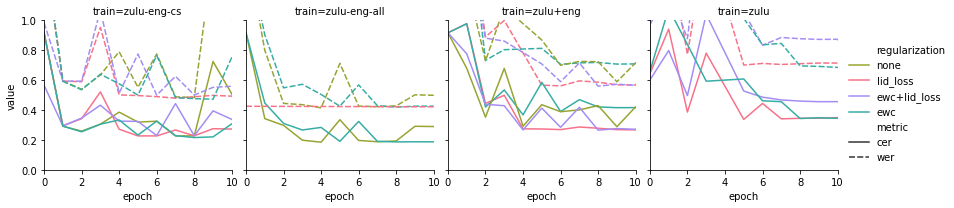

In [236]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (~df['experiment_name'].str.contains('tira')) &
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['tira-clean-split', 'sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    # col_wrap=2,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='metric',
    # style='tag',
)
# g.set_titles('lm={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

In [237]:
df.loc[
    (df['train_data']=='zulu')&
    (df['regularization']=='none')&
    (df['epoch']==1)&
    (df['dataset']=='sasoc-cs')&
    (df['metric']=='cer')
]

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff


In [238]:
df[df['beam']>0]

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
10482,1048,eval_steps_per_second,0.045000,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
10422,1048,eval_loss,5.006366,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,0.000000
10432,1048,eval_model_preparation_time,0.002300,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
10442,1048,eval_wer,3.241379,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,1,wer,sasoc-cs,False,False,none,zulu-eng-all,NaN
10452,1048,eval_cer,2.004213,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,1,cer,sasoc-cs,False,False,none,zulu-eng-all,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10571,10480,eval_loss,7.509797,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,0.080204
10441,10480,eval_model_preparation_time,0.002500,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,False,False,none,zulu-eng-all,NaN
10521,10480,eval_wer,2.468710,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2,0.0,False,-1,...,nan,2.0,10,wer,sasoc-cs,False,False,none,zulu-eng-all,NaN
10481,10480,eval_samples_per_second,0.230000,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,False,False,none,zulu-eng-all,NaN


In [239]:
df.sort_values('date', ascending=False)

,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
4004,2096,eval/samples_per_second,8.824000,whisper-small-zulu-eng-all-lid-alpha-0.2,1900-02-11 11:41:14,NaN,NaN,0.2,False,-1,...,nan,0.0,0,,sasoc-cs,False,True,lid_loss,zulu-eng-all,NaN
4008,7000,train/grad_norm,0.405845,whisper-small-zulu-eng-all-lid-alpha-0.2,1900-02-11 11:41:14,NaN,NaN,0.2,False,-1,...,nan,0.0,0,,None,False,True,lid_loss,zulu-eng-all,NaN
4005,3144,eval/steps_per_second,1.009000,whisper-small-zulu-eng-all-lid-alpha-0.2,1900-02-11 11:41:14,NaN,NaN,0.2,False,-1,...,nan,0.0,0,,sasoc-cs,False,True,lid_loss,zulu-eng-all,NaN
4002,0,eval/loss,5.160970,whisper-small-zulu-eng-all-lid-alpha-0.2,1900-02-11 11:41:14,NaN,NaN,0.2,False,-1,...,nan,0.0,0,,sasoc-cs,False,True,lid_loss,zulu-eng-all,0.000000
4003,1048,eval/runtime,27.839701,whisper-small-zulu-eng-all-lid-alpha-0.2,1900-02-11 11:41:14,NaN,NaN,0.2,False,-1,...,nan,0.0,0,,sasoc-cs,False,True,lid_loss,zulu-eng-all,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10571,10480,eval_loss,7.509797,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,0.080204
10441,10480,eval_model_preparation_time,0.002500,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,False,False,none,zulu-eng-all,NaN
10521,10480,eval_wer,2.468710,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2,0.0,False,-1,...,nan,2.0,10,wer,sasoc-cs,False,False,none,zulu-eng-all,NaN
10481,10480,eval_samples_per_second,0.230000,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,-1,...,0.5,2.0,10,,sasoc-cs,False,False,none,zulu-eng-all,NaN


In [240]:
df.loc[
    ~(df['experiment_name'].str.contains('tira')) &
    # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
    (df['dataset']=='sasoc-cs') &
    (df['ewc_lambda'].isin([1])) &
    (df['lid_loss_alpha'].isin([0.2])) &
    # (df['regularization']=='none')&
    # (df['epoch']>20)&
    # (df['epoch']>25)&
    (df['metric']=='wer'),
    ['epoch', 'step', 'value', 'experiment_name', 'lang_prompt', 'tag']
].sort_values('value')

,epoch,step,value,experiment_name,lang_prompt,tag
6552,19,6650,0.471903,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
6561,28,9800,0.473819,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
6545,12,4200,0.474457,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
6563,0,10500,0.475734,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
6562,29,10150,0.475734,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
...,...,...,...,...,...,...
8949,0,0,1.492337,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,swahili,eval/sasoc-cs-en+sw_wer
10380,0,0,1.492337,whisper-small-zulu-swahili-lid-alpha-0.2-ewc-l...,swahili,eval/sasoc-cs-en+sw_wer
6533,0,0,1.492337,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
8950,1,699,1.536398,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,swahili,eval/sasoc-cs-en+sw_wer
